# Analysis

In [1]:
import praw
from praw import models
import json
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from transformers import logging
logging.set_verbosity_error()

C:\Users\olive\AppData\Roaming\Python\Python38\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\ProgramData\Anaconda3\lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# load in API key
with open('secret.json') as f:
  secretRAW = f.read()
secret = json.loads(secretRAW)

In [3]:
# initialize API wrapper instance
reddit = praw.Reddit(
    client_id= secret["id"],
    client_secret= secret["secret"],
    password= secret["pass"],
    user_agent="r/Politics NLP Scraper",
    username= secret["user"],
)

In [4]:
# Select subreddit
rPolitics = reddit.subreddit("politics")

In [5]:
# Gather at most 100 posts from selected subreddit over the past month

posts = []
for post in rPolitics.top(time_filter = "month", limit=100):
    posts.append(post)
len(posts)

100

In [6]:
# Perform NER on post titles
def NER(text):
    tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
    model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

    nlp = pipeline("ner", model=model, tokenizer=tokenizer)

    ner_results = nlp(text)

    return ner_results

In [7]:
postTextNER = {}
for post in tqdm(posts): # test on first entry [:1]):
    postTextNER[post.id] = {}
    postTextNER[post.id]["post"] = {}
    postTextNER[post.id]["post"]["title"] = []
    postTextNER[post.id]["post"]["title"].append(post.title)
    postTextNER[post.id]["post"]["title"].append(NER(post.title))

    post.comments.replace_more()
    postTextNER[post.id]["comments"] = {}
    for i, comment in enumerate(post.comments):
        if comment != praw.models.MoreComments:
            if "I am a bot" not in comment.body:
                postTextNER[post.id]["comments"][i] = comment.body

out_file = open("NER.json", "w")
json.dump(str(postTextNER), out_file)
out_file.close()

 55%|████████████████████████████████████████████▌                                    | 55/100 [25:13<20:38, 27.52s/it]


TooManyRequests: received 429 HTTP response

In [8]:
# BERT searches for the smallest unit of a name that it recognizes and so often splits up names into multiple parts
# (eg. B, ##iden)
# So this function combines all parts of names into one name string
# The way it works necessitates that all parts of a name form one consecutive string
# (eg. DonaldTrump)
# This does lead to errors where if only the name Trump appears in one post title and Donald Trump appears in another,
# they would be categorized as two separate names.
# This is, however, unavoidable because to merge names on the basis of similarity might also merge names of two different people
# that share a first or last name.

def extractNames(textNER):
    names = {}
    removeHashtags = str.maketrans('', '', '#')
    for id,post in textNER.items():
        names[id] = []
        nameParts = []
        nameInds = []
        for unit in post['post']['title'][1]:
            if "PER" in unit['entity'] :
                nameParts.append(unit['word'])
                nameInds.append(unit['index'])

        # print(id, nameParts)

        if len(nameParts) > 1:
            # Pad out end of lists so the else statement triggers at the end no matter what.
            nameInds = nameInds + [nameInds[-1]+1] + [nameInds[-1]+3]
            nameParts = nameParts + ["NULL"] + ["NULL"]
            subNameParts = []

            for ind, name in list(zip(nameInds, nameParts))[:1]:
                # print("0", id, ind, name)

                if nameInds[1] - nameInds[0] > 1:
                    nameStr = name.translate(removeHashtags)
                    names[id].append(nameStr)

            i=1
            for ind, name in list(zip(nameInds, nameParts))[1:]:
                # print("1+", id, i, ind, name)
                if nameInds[i] - nameInds[i-1] == 1:
                    # print(name)
                    if nameParts[i-1] not in subNameParts:
                        subNameParts.append(nameParts[i-1])
                    if name not in subNameParts:
                        subNameParts.append(name)
                else:
                    if len(subNameParts) > 0:
                        if "NULL" in subNameParts:
                            subNameParts.remove("NULL")
                        nameStr = ''.join(subNameParts).translate(removeHashtags)
                        names[id].append(nameStr)
                        subNameParts = []
                i+=1
        elif len(nameParts) == 1:
            # print("==1", id, nameParts[0])
            names[id].append(nameParts[0])

    return names

In [9]:
# Extract names from post titles and remove posts without names in their title

names_and_ids = extractNames(postTextNER)
for id, names in names_and_ids.items():
    if len(names) > 0:
        postTextNER[id]["names"] = names
    else:
        postTextNER.pop(id)

In [10]:
# Perform sentiment analysis on comments within posts
# returns whether the overall sentiment was positive or negative
# as well as the total "score" which is the sum of all confidence metrics
# (negative if sentiment is negative and positive if sentiment is positive)

def sentimentAnalysis(post):
    pipe = pipeline(model="distilbert-base-uncased-finetuned-sst-2-english")

    inputs = []
    for ind, comment in post["comments"].items():
        inputs.append(comment)

    outputs = pipe(inputs)

    total = 0
    for out in outputs:
        if out["label"] == "POSITIVE":
            total += out["score"]
        elif out["label"] == "NEGATIVE":
            total -= out["score"]

    if total > 0:
        return "POSITIVE", abs(total)
    elif total < 0:
        return "NEGATIVE", abs(total)
    else:
        return "AMBIGUOUS", 0

In [11]:
for post in tqdm(postTextNER.values()):
    try:
        post["sentiment"] = sentimentAnalysis(post)
    except:
        post["sentiment"] = ("ERROR", 0)

out_file = open("Sentiments.json", "w")
json.dump(str(postTextNER), out_file)
out_file.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [10:56<00:00, 13.39s/it]


In [12]:
# Combine all sentiments into a dict with names as keys and a list of all sentiment scores as values
# Count the occurrences of each name and store that in a dict

nameSentiments = {}
nameOccurrence = {}

for post in postTextNER.values():
    for name in post["names"]:
        nameSentiments[name] = []
        nameOccurrence[name] = 0

for post in postTextNER.values():
    for name in nameSentiments.keys():
        if name in post["names"]:
            nameSentiments[name].append(post["sentiment"])
            nameOccurrence[name] += 1

In [13]:
# Add all sentiment scores together and store in a dict
# Average total sentiment scores by the number of posts and store that in a dict

nameTotalSentiment = {}
nameAvgSentimentPerPost = {}

for name, sentiments in nameSentiments.items():

    total = 0
    for sentiment in sentiments:
        if sentiment[0] == "POSITIVE":
            total += sentiment[1]
        elif sentiment[0] == "NEGATIVE":
            total -= sentiment[1]

    nameTotalSentiment[name] = total
    nameAvgSentimentPerPost[name] = total / nameOccurrence[name]

# Visualizations

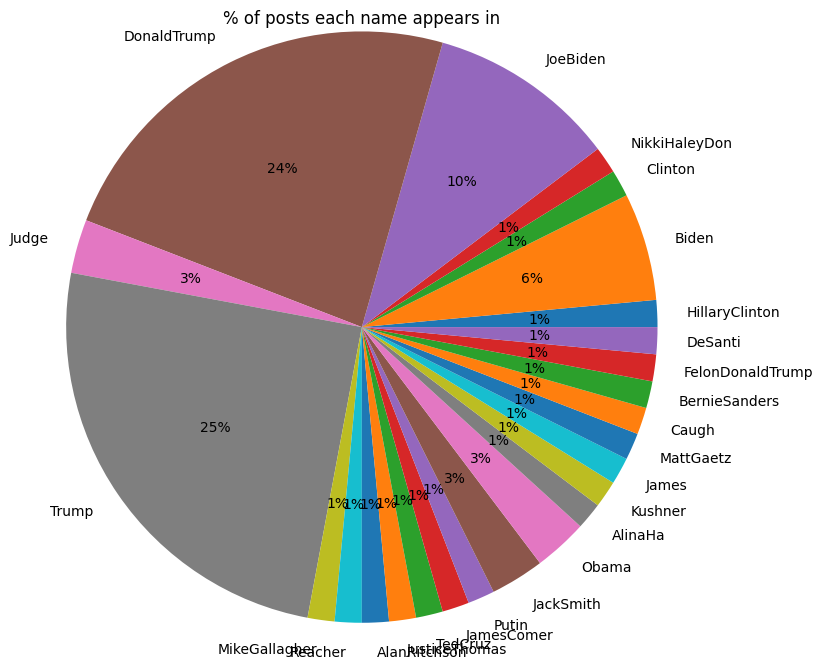

In [14]:
data = pd.Series(nameOccurrence)
plt.pie(data.values, labels=data.index, autopct='%.0f%%', radius=2)
plt.title("% of posts each name appears in", y=1.3)
plt.show()

In [15]:
threshold = 2

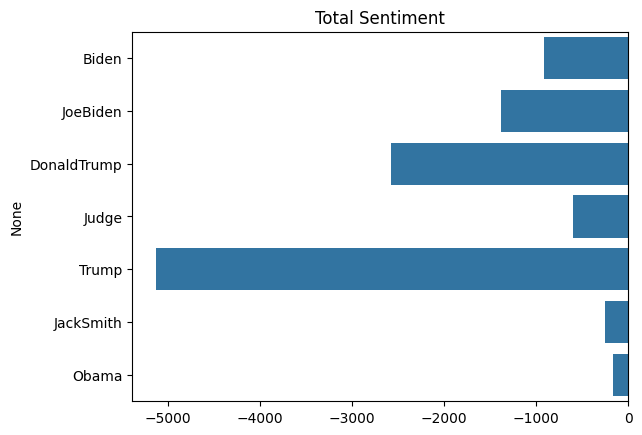

In [16]:
data = pd.Series(nameTotalSentiment)
data = data.drop([name for name, sentiment in data.items() if nameOccurrence[name] < threshold])
sns.barplot(x=data.values, y=data.index)
plt.title("Total Sentiment")
plt.show()

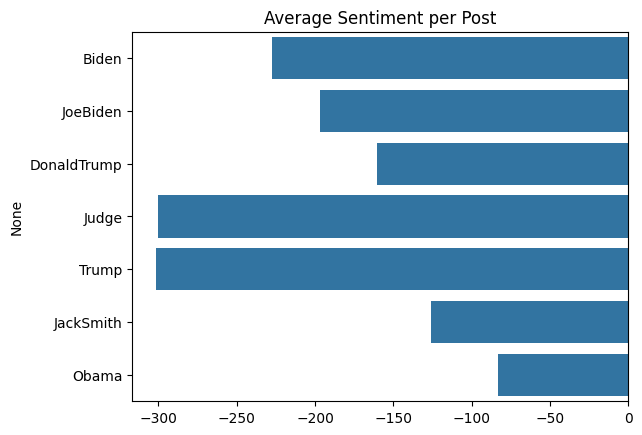

In [17]:
data = pd.Series(nameAvgSentimentPerPost)
data = data.drop([name for name, sentiment in data.items() if nameOccurrence[name] < threshold])
sns.barplot(x=data.values, y=data.index)
plt.title("Average Sentiment per Post")
plt.show()

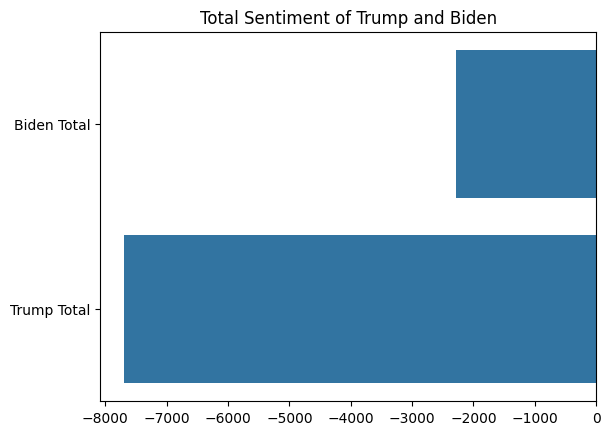

In [22]:
bidenTotal = nameTotalSentiment["Biden"] + nameTotalSentiment["JoeBiden"]
trumpTotal = nameTotalSentiment["Trump"] + nameTotalSentiment["DonaldTrump"]

sns.barplot(x=[bidenTotal, trumpTotal], y=["Biden Total", "Trump Total"])
plt.title("Total Sentiment of Trump and Biden")
plt.show()

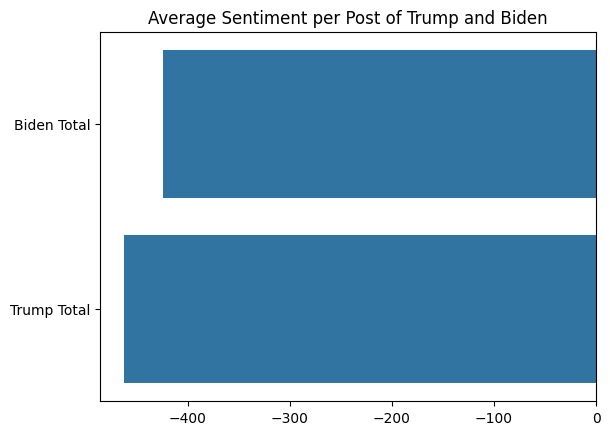

In [21]:
bidenTotal = nameAvgSentimentPerPost["Biden"] + nameAvgSentimentPerPost["JoeBiden"]
trumpTotal = nameAvgSentimentPerPost["Trump"] + nameAvgSentimentPerPost["DonaldTrump"]

sns.barplot(x=[bidenTotal, trumpTotal], y=["Biden Total", "Trump Total"])
plt.title("Average Sentiment per Post of Trump and Biden")
plt.show()